In [1]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import torch
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import io
import matplotlib.pyplot as plt

In [2]:

dataset_path = "/kaggle/input/allphot/combined_file.csv"  # Замените на ваш путь к CSV-файлу
data = pd.read_csv(dataset_path)


print(data.head())

                                                 url  label  Unnamed: 0
0  //avatars.mds.yandex.net/get-realty-offers/136...      5         NaN
1  //avatars.mds.yandex.net/get-realty-offers/988...      5         NaN
2  //avatars.mds.yandex.net/get-realty-offers/127...      5         NaN
3  //avatars.mds.yandex.net/get-realty-offers/138...      5         NaN
4  //avatars.mds.yandex.net/get-realty-offers/101...      5         NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7203 entries, 0 to 7202
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   url         7203 non-null   object 
 1   label       7203 non-null   int64  
 2   Unnamed: 0  0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 168.9+ KB


In [4]:
data = data.drop('Unnamed: 0',axis=1 )

In [5]:
data = data[data["label"] != 0]   # мусор

In [6]:
data

,url,label
0,//avatars.mds.yandex.net/get-realty-offers/136...,5
1,//avatars.mds.yandex.net/get-realty-offers/988...,5
2,//avatars.mds.yandex.net/get-realty-offers/127...,5
3,//avatars.mds.yandex.net/get-realty-offers/138...,5
4,//avatars.mds.yandex.net/get-realty-offers/101...,5
...,...,...
7167,//avatars.mds.yandex.net/get-realty-offers/150...,4
7168,//avatars.mds.yandex.net/get-realty-offers/127...,4
7169,//avatars.mds.yandex.net/get-realty-offers/146...,4
7175,//avatars.mds.yandex.net/get-realty-offers/147...,2


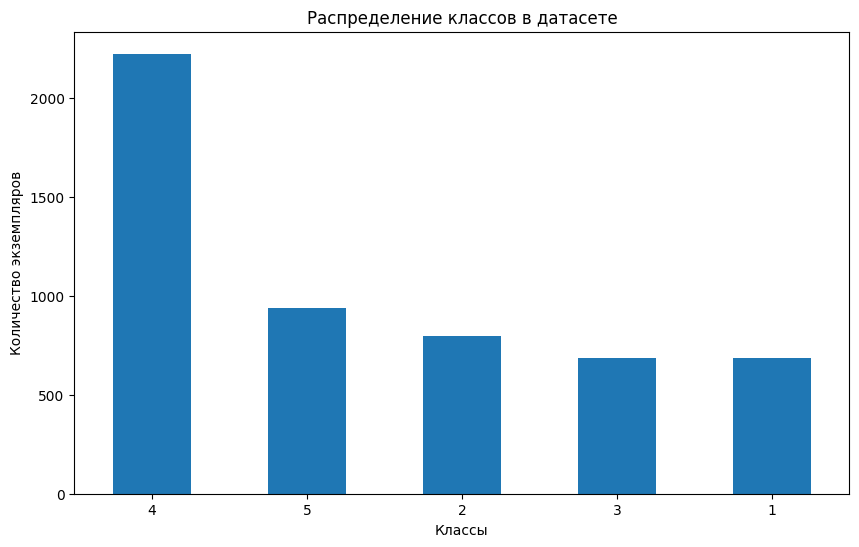

In [7]:
import pandas as pd


class_counts = data['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Распределение классов в датасете')
plt.xlabel('Классы')
plt.ylabel('Количество экземпляров')
plt.xticks(rotation=0)  # Установка меток по оси X без наклона
plt.show()


In [9]:
data['label'] = data['label'].replace({1: 1, 3: 1})

# Заменяем 4 и 5 на 4 (или любое другое значение)
data['label'] = data['label'].replace({4: 3, 5: 3})


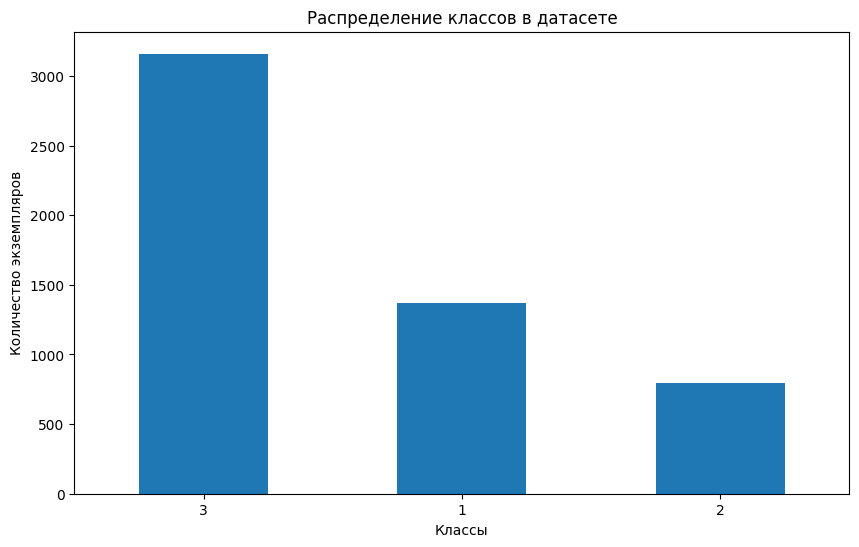

In [10]:
class_counts = data['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Распределение классов в датасете')
plt.xlabel('Классы')
plt.ylabel('Количество экземпляров')
plt.xticks(rotation=0)  # Установка меток по оси X без наклона
plt.show()

In [16]:
import pandas as pd

classes_to_reduce = [1, 3]


reduction_factor1 = 0.4
reduction_factor2 = 0.73


balanced_df = pd.DataFrame()

for class_label in classes_to_reduce:

    class_data = data[data['label'] == class_label]

    if class_label == 3:
        num_to_keep = int(len(class_data) * (1 - reduction_factor2))
    else:
        num_to_keep = int(len(class_data) * (1 - reduction_factor1))

    reduced_class_data = class_data.sample(num_to_keep, random_state=42)  # random_state для воспроизводимости


    balanced_df = pd.concat([balanced_df, reduced_class_data])


other_classes = data[~data['label'].isin(classes_to_reduce)]
balanced_df = pd.concat([balanced_df, other_classes])


balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


print(balanced_df['label'].value_counts())

label
3    853
1    822
2    796
Name: count, dtype: int64


In [17]:
import pandas as pd
import concurrent.futures
import requests

def get_image(url):

    if ("https:" not in url):
        url = "https:" + url
    try:
        response = requests.get(url)
        response.raise_for_status()  # Проверка на ошибки
        return response.content  
    except Exception as e:
        print(f"Ошибка при загрузке {url}: {e}")
        return None

def load_images_with_labels(data, url_column='url', label_column='label', num_thread=5, batch_size=100):
    images = []
    image_labels = []

    urls = data[url_column].tolist()  # Получаем список URL из DataFrame
    labels = data[label_column].tolist() if label_column in data.columns else [None] * len(urls)  # Получаем список меток из DataFrame, если есть

    # Разбиваем на пакеты
    for i in range(0, len(urls), batch_size):
        batch_urls = urls[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        with concurrent.futures.ThreadPoolExecutor(max_workers=num_thread) as executor:
            future_to_url = {executor.submit(get_image, url): (url, label) for url, label in zip(batch_urls, batch_labels)}

            for future in concurrent.futures.as_completed(future_to_url):
                url, label = future_to_url[future]
                try:
                    image = future.result()
                    if image:
                        images.append(image)
                        image_labels.append(label)
                except Exception as e:
                    print(f"Ошибка при обработке {url}: {e}")

    return images, image_labels


images, image_labels = load_images_with_labels(balanced_df)



In [18]:
data = balanced_df

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


images_tensor = []
for img_bytes in images:
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    img_tensor = transform(img)
    images_tensor.append(img_tensor)

images_tensor = torch.stack(images_tensor)


In [28]:
image_labels = [label + 1 for label in image_labels]



In [31]:
num_classes = 3


In [32]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchvision import datasets, transforms, models
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR


criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.001)  # Начальный learning rate


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


model.train()
num_epochs = 20
for epoch in range(num_epochs):
    for i in range(len(images_tensor)):
        inputs = images_tensor[i].unsqueeze(0).to(device)
        target = torch.tensor(image_labels[i], dtype=torch.long).unsqueeze(0).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 1.0495
Epoch [2/20], Loss: 1.0349
Epoch [3/20], Loss: 0.9693
Epoch [4/20], Loss: 1.0451
Epoch [5/20], Loss: 1.0428
Epoch [6/20], Loss: 1.0485
Epoch [7/20], Loss: 0.9701
Epoch [8/20], Loss: 1.0680
Epoch [9/20], Loss: 1.0262
Epoch [10/20], Loss: 1.0634
